In [1]:
import math
import numpy as np

In [2]:
# Assuming data format: {(x, y, z): 'block_type'}
m = {}  # input map
graph = {}
stateful_graph = {}
Fsafe = 3
jump_height = 1 

In [3]:
world_txt_filename = 'benchmark/superflat/world-dump.txt'

In [4]:
with open(world_txt_filename, 'r') as file:
    lines = file.readlines()

In [5]:
for line in lines:
    if line.startswith('b'):
        parts = line.split() 
        x, z, y = map(int, parts[1:4]) 
        block_type = parts[4] 
        m[(x, y, z)] = block_type


In [6]:
def add_edge(x1, y1, z1, x2, y2, z2):
    distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    graph.setdefault((x1, y1, z1), []).append(((x2, y2, z2), distance))
    
def is_reachable(x, y, z):
    return m.get((x, y, z)) == 'solid' and m.get((x, y, z + 1)) != 'solid'

In [7]:
def construct_graph():
    for (x, y, z), block_type in m.items():
        # if not is_reachable(x, y, z):
        #     continue
        graph.setdefault((x, y, z), [])
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]: # we only consider moving 4 dirs
            for dz in range(jump_height, -Fsafe - 1, -1):
                nx, ny, nz = x + dx, y + dy, z + dz
                if nz < z and m.get((nx, ny, z)) == 'solid':
                    continue
                elif is_reachable(nx, ny, nz):
                    add_edge(x, y, z, nx, ny, nz)
                    break

In [8]:
graph = {}
construct_graph()

In [9]:
# graph

In [10]:
def add_edge_with_resource(x1, y1, z1, k1, x2, y2, z2, k2, ex_cost):
    distance = math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2)
    stateful_graph.setdefault(((x1, y1, z1), k1), []).append((((x2, y2, z2), k2), distance + ex_cost))
    
def construct_graph_with_resources(K):
    for (x, y, z), block_type in m.items():
        for k in range(K+1):  
            stateful_graph.setdefault(((x, y, z), k), [])
            for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
                for dz in [0, 1]: # can only destruct block at z+1
                    nx, ny, nz = x + dx, y + dy, z + dz
                    # no block or not solid or have resource
                    # if (x, y, z) == (-4, 1, 60):
                    #     print("des:", nx, ny, nz, m[(nx, ny, nz)])
                    if m.get((nx, ny, nz)) == 'solid' and k > 0:
                        nk = k - 1
                        m[(nx, ny, nz)] = 'air'
                        if is_reachable(nx, ny, nz-1):
                            add_edge_with_resource(x, y, z, k, nx, ny, nz-1, nk, 1) 
                        m[(nx, ny, nz)] = 'solid'
                for dz in range(jump_height, -Fsafe - 1, -1):
                    nx, ny, nz = x + dx, y + dy, z + dz
                    # if (x, y, z) == (-4, 1, 60):
                    #     print("reg:", nx, ny, nz, m[(nx, ny, nz)])
                    if is_reachable(nx, ny, nz):
                        add_edge_with_resource(x, y, z, k, nx, ny, nz, k, 0) 
                        break            
           

In [11]:
K = 5

stateful_graph = {}
construct_graph_with_resources(K)

In [12]:
# stateful_graph

In [13]:
import math
from queue import PriorityQueue

# Assuming graph is already defined as shown in previous examples

def euclidean_distance(x1, y1, z1, x2, y2, z2):
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2 + (z2 - z1) ** 2)

def a_star_search(start, goal):
    open_set = PriorityQueue()
    open_set.put((0, start))
    
    came_from = {}
    g_score = {node: float('inf') for node in graph}
    g_score[start] = 0
    
    f_score = {node: float('inf') for node in graph}
    f_score[start] = euclidean_distance(*start, *goal)
    
    while not open_set.empty():
        current = open_set.get()[1]  # Get node with lowest f_score value
        
        if current == goal:
            path = [current]
            total_cost = g_score[current]  # Total cost to reach the goal
            while current in came_from:
                current = came_from[current]
                path.append(current)
            path.reverse()
            return path, total_cost
        
        for neighbor, distance in graph[current]:
            tentative_g_score = g_score[current] + distance
            
            if tentative_g_score < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g_score
                f_score[neighbor] = g_score[neighbor] + euclidean_distance(*neighbor, *goal)
                open_set.put((f_score[neighbor], neighbor))
    
    return False, 0 



In [14]:
# # Example usage
# start = (288, -464, -61)
# goal = (302, -331, -61)
# path, cost = a_star_search(start, goal)
# print("Path:", path)
# print("Total cost:", cost)

In [15]:
def a_star_search_with_resources(start, goal, K):
    open_set = PriorityQueue()
    # Adjust the start node format to include the resource count within the tuple
    open_set.put((0, (start, K)))  # Start node now properly includes initial resources
    
    came_from = {}
    g_score = {((x, y, z), k): float('inf') for ((x, y, z), k) in stateful_graph}
    g_score[(start, K)] = 0  # Initialize g_score for the start node with resources
    
    f_score = {((x, y, z), k): float('inf') for ((x, y, z), k) in stateful_graph}
    f_score[(start, K)] = euclidean_distance(*start, *goal)  # Initialize f_score
    while not open_set.empty():
        # Adjusted to retrieve ((x, y, z), k) format directly
        current_cost, (current_pos, current_k) = open_set.get()
        
        if current_pos == goal:
            path = [(current_pos, current_k)]
            total_cost = g_score[(current_pos, current_k)]
            while (current_pos, current_k) in came_from:
                current_pos, current_k = came_from[(current_pos, current_k)]
                path.append((current_pos, current_k))
            path.reverse()
            return path, total_cost  # Path reconstructed from goal to start
        
        for (neighbor, k_rest), distance in stateful_graph[(current_pos, current_k)]:
            tentative_g_score = g_score[(current_pos, current_k)] + distance
            
            if tentative_g_score < g_score[(neighbor, k_rest)]:
                # Update the path and scores for better path
                came_from[(neighbor, k_rest)] = (current_pos, current_k)
                g_score[(neighbor, k_rest)] = tentative_g_score
                f_score[(neighbor, k_rest)] = tentative_g_score + euclidean_distance(*neighbor, *goal)
                open_set.put((f_score[(neighbor, k_rest)], (neighbor, k_rest)))
    
    return False, 0


In [16]:
# start = (0, 1, 0)
# goal = (2, 1, 0)

start = (288, -464, -61)
goal = (313, -404, -61)

# 288 -64 -464
# 313 -61 -404
# (239, 326, -428, -361)
K = 5

path1, cost1 = a_star_search(start, goal)
print("Path:", path1)
print("Total cost:", cost1)

path2, cost2 = a_star_search_with_resources(start, goal, K)
print("Path:", path2)
print("Total cost:", cost2)


Path: [(288, -464, -61), (288, -463, -61), (288, -462, -61), (288, -461, -61), (288, -460, -61), (288, -459, -61), (288, -458, -61), (288, -457, -61), (288, -456, -61), (288, -455, -61), (288, -454, -61), (288, -453, -61), (288, -452, -61), (288, -451, -61), (288, -450, -61), (288, -449, -61), (288, -448, -61), (288, -447, -61), (288, -446, -61), (288, -445, -61), (288, -444, -61), (288, -443, -61), (288, -442, -61), (288, -441, -61), (288, -440, -61), (288, -439, -61), (288, -438, -61), (289, -438, -61), (290, -438, -61), (291, -438, -61), (292, -438, -61), (293, -438, -61), (293, -437, -61), (293, -436, -61), (293, -435, -61), (293, -434, -61), (293, -433, -61), (293, -432, -61), (293, -431, -61), (293, -430, -61), (293, -429, -61), (293, -428, -61), (293, -427, -61), (293, -426, -61), (293, -425, -61), (293, -424, -61), (293, -423, -61), (294, -423, -61), (294, -422, -61), (295, -422, -61), (295, -421, -61), (296, -421, -61), (296, -420, -61), (297, -420, -61), (297, -419, -61), (29

In [17]:
import matplotlib.pyplot as plt

def parse_path(path):
    xy_path = [(x, y) for x, y, _ in path]
    
    return xy_path

def parse_path_resource(path):
    xy_path = [(x, y) for (x, y, z), k in path]
    
    return xy_path

<module 'matplotlib.pyplot' from '/Users/guodw/miniforge3/envs/virt/lib/python3.9/site-packages/matplotlib/pyplot.py'>

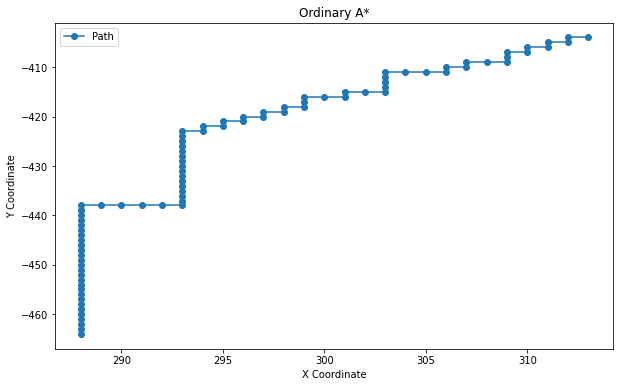

In [18]:
parsed_path = parse_path(path1)
x, y = zip(*parsed_path)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Path", marker='o')

# plt.axis('square')
# plt.xlim(0, 3)
# plt.ylim(0, 3)

# plt.xticks([-1, 0, 1, 2, 3])
# plt.yticks([-1, 0, 1, 2, 3])

# Adding titles and labels
plt.title("Ordinary A*")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt

<module 'matplotlib.pyplot' from '/Users/guodw/miniforge3/envs/virt/lib/python3.9/site-packages/matplotlib/pyplot.py'>

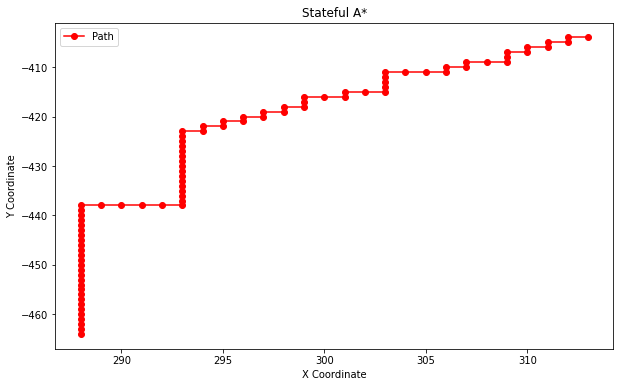

In [19]:
parsed_path = parse_path_resource(path2)
x, y = zip(*parsed_path)
plt.figure(figsize=(10, 6))
plt.plot(x, y, label="Path", marker='o', color = 'red')

# plt.axis('square')
# plt.xlim(0, 3)
# plt.ylim(0, 3)

# plt.xticks([-1, 0, 1, 2, 3])
# plt.yticks([-1, 0, 1, 2, 3])


# Adding titles and labels
plt.title("Stateful A*")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.legend()
plt